### Logistic Regression (LogRegChoice.ipynb)
Train a differentially private logistic regression model while trying to optimize the choice of the regularization hyperparameter.

Goal: See how a ChoiceMaker performs on "easier" DP problems where a
probabilistic bound (from the ERM method) can be derived. Numbers that aren't significantly worse than
ERM are acceptable here.

Comparison: Differentially private ERM. We implement private logistic
regression, the ERM method, and a ChoiceMaker. We compare the misclassification rates of the algorithms.

Current Results: The Choicemaker performs better than ERM for low values of epsilon which is quite interesting.
It performs better than all three algorithms do as well.

In [1]:
#Add the fork of sklearn to the path.
import sys, os
sys.path = ['./scikit-learn/build/lib.linux-x86_64-3.6/'] + sys.path
import sklearn
from sklearn import model_selection, feature_selection
from sklearn.tree import export_graphviz
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from log_regression import test, DPLogisticRegression
from ChoiceMaker import DTChoice
import ChoiceMaker
import graphviz
import copy
%matplotlib inline
import pickle

In [2]:
#This method is for saving checkpoints, as some of our computations are expensive.
#If you want to run the code yourself, then simply delete the corresponding .pkl file in 
#the log_regression_metadata/ folder
def load_or_run(name, f):
    name = 'log_regression_metadata/' + name
    try:
        r = pickle.load(open(name, 'rb'))
    except:
        r = f()
        pickle.dump(r, open(name, 'wb'))
    return r

### ChoiceMaker Classes

In [3]:
"""Error method implemented as cross validation score on the dataset"""
def manual_CV(db, parts, clf):
    kf = model_selection.KFold(parts)
    arr = []
    for train_idx, test_idx in kf.split(db.X):
        X_test = db.X.iloc[test_idx]
        y_test = db.y.iloc[test_idx]
        X_train = db.X.iloc[train_idx]
        y_train = db.y.iloc[train_idx]
        #Have to fix case when only one class exists
        if len(np.unique(y_train)) == 1:
            score = (y_train == y_train.iloc[0]).sum() / len(y_train)
            arr.append(score)
        else:
            clf.fit(X_train, y_train)
            arr.append(clf.score(X_test, y_test))
    return np.array(arr)

In [4]:
"""Logistic Regression algorithm class instantiated with a C value."""
class DP:
    def __init__(self, C):
        self.numruns = 0
        self.name = str(C)
        self.model = DPLogisticRegression(0.1, C=C, K=1.02, fit_intercept=True)
    def error(self, db):
        #5-way CV score.
        A = manual_CV(db, 5, self.model)
        return 1.0-A.mean()
    def run(self, db):
        self.numruns += 1
        self.model.set_epsilon(db.epsilon)
        return self.model.fit(db.X, db.y)

In [5]:
class DB:
    def __init__(self, X, y, epsilon=1):
        self.epsilon = epsilon
        self.ncol = X.shape[1]
        self.X = pd.get_dummies(X)
        self.y = y

In [6]:
"""Metafeatures used"""
"""Metafeatures used.  Note that the size of the
dataset is considered public; the adjacency relation
allows changing the value of a record, but not deleting it."""
class DBMetafeatures:
    def __init__(self):
        self.sensitivities = {'nrow': 0, 'ncol': 0, 'eps': 0, 'numy': 1}
    
    def __call__(self, dataset):
        return {'nrow': dataset.X.shape[0], 
                'ncol': dataset.ncol,
                'eps': dataset.epsilon, 
                'numy': dataset.y.sum()}

#### Methods for slicing datasets, allowing us to make a larger test set for our ChoiceMaker

In [7]:
def reshape_dset(db, ncol, nrow, y_ratio, seed=12345, prng=None):
    """Rescales an input database to the desired parameters.
    Parameters
    ----------
    db: Input array. We assume last col is the output col.
        The output col must be binary.
        
    ncol: Desired number of columns in output.
    
    nrow: Desired number of rows.
    
    y_ratio: Desired percentage of class 2 in the output
    
    seed: seed value to use. Default: 12345
    
    prng: random number generator. One of seed or prng must not be None. 
    """
    if(prng == None):
        prng = np.random.RandomState(seed)
    ys = db[db.columns[-1]]
    v1, v2 = ys.unique()[:2]
    Z1 = db[ys == v1]
    s1 = int(y_ratio*nrow)
    Z2 = db[ys == v2]
    s2 = nrow - s1
    def reshape(Z, nrow):
        db = pd.DataFrame()
        while db.shape[0] + Z.shape[0] < nrow:
            db = pd.concat((db, Z), ignore_index=True)
        return pd.concat((db, Z.sample(nrow - db.shape[0])), ignore_index=True)
    db = pd.concat((reshape(Z1, s1), reshape(Z2, s2)), ignore_index=True)
    db_x = db[db.columns[:-1]]
    ys = db[db.columns[-1]]
    db = pd.DataFrame()
    while db.shape[1] + db_x.shape[1] < ncol:
        db = pd.concat((db, db_x), axis=1, ignore_index=True)
    rand_cols = np.random.choice(db_x.columns, ncol-db.shape[1], replace=False)
    return pd.concat((db, db_x[rand_cols], ys), axis=1, ignore_index=True).sample(frac=1)

def gen_tset_size_range(eps_vals, col_vals, row_vals, ratios, reps, db, prng=None):
    """performs reshape_dset for each member of the cross product of the arguments
    
    Params:
    db: Database to perform surgery on
    """
    for c in col_vals:
        for r in row_vals:
            for e in eps_vals:
                for ratio in ratios:
                    for x in range(0, reps):
                        G = reshape_dset(db, ncol=c, nrow=r, y_ratio=ratio, prng=prng)
                        ncol = adult.shape[1]
                        last_name = G.columns[-1]
                        yield DB(G.drop([last_name], axis=1), G[last_name], e)

### Load Datasets

In [8]:
adult = pickle.load(open('log_regression_data/adult_preprocess.pkl', 'rb'))
magic = pickle.load(open('log_regression_data/magic_preprocess.pkl', 'rb'))
default = pickle.load(open('log_regression_data/default_preprocess.pkl', 'rb'))
lending = pickle.load(open('log_regression_data/lending_preprocess.pkl', 'rb'))

In [33]:
prng = np.random.RandomState(12345)
eps_vals = [0.1, 0.2, 0.4, 0.8, 1.6, 3.2]
col_vals = np.arange(2, 20, 2)
row_vals = [20, 40, 100, 150, 300, 600, 1000, 2000, 3000]
ratios = [0.15, 0.3, 0.5, 0.7, 0.85]
num_reps = 3
C_list = [0.1, 0.5, 1.0]
alg_list = lambda: dict([(str(x), DP(C=x)) for x in C_list])
def split_db(db, prng=None):
    return gen_tset_size_range(eps_vals, col_vals, row_vals, ratios, num_reps, db, prng)

In [20]:
#These four lists contain all the datasets we use for our experiment.
adult_data = list(split_db(adult, prng))
default_data = list(split_db(default, prng))
lending_data = list(split_db(lending, prng))
magic_data = list(split_db(magic, prng))

KeyboardInterrupt: 

In [36]:
adult_data = pickle.load(open('log_regression_metadata2/adult_slices.pkl', 'rb'))
default_data = pickle.load(open('log_regression_metadata2/default_slices.pkl', 'rb'))
lending_data = pickle.load(open('log_regression_metadata2/lending_slices.pkl', 'rb'))
magic_data = pickle.load(open('log_regression_metadata2/magic_slices.pkl', 'rb'))

### Experiment

##### Setup
We have four dataset lists, each containing slices of a dataset. We train train four
choicemakers in method inspired by cross-validation:
Choicemaker i uses all partitions except for i as training data and is then tested on list i.
Testing involves computing the error for each of the base algorithms, the choicemaker, ERM,
and non-private cross-validation, averaged over each dataset in list i.

In [13]:
#ChoiceMaker is abbreviated as cm
def get_cm(db):
    return DTChoice(db, DBMetafeatures(), {a.name: a for a in alg_list})

In [37]:
adult_cm = load_or_run('adult_cm.pkl', lambda: get_cm(adult_data))
adult_cm.model = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=10, max_depth=2)
adult_cm.retrain_model()
adult_cm.algs = alg_list()

In [38]:
default_cm = load_or_run('default_cm.pkl', lambda: get_cm(default_data))
default_cm.model = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=10, max_depth=2)
default_cm.retrain_model()
default_cm.algs = alg_list()

In [39]:
lending_cm = load_or_run('lending_cm.pkl', lambda: get_cm(lending_data))
lending_cm.model = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=10, max_depth=2)
lending_cm.retrain_model()
lending_cm.algs = alg_list()

In [40]:
magic_cm = load_or_run('magic_cm.pkl', lambda: get_cm(magic_data))
magic_cm.model = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=10, max_depth=2)
magic_cm.retrain_model()
magic_cm.algs = alg_list()

In [41]:
"""
{dbname}_test_cm contains all databases which are not named {dbname} as training data.
"""

default_test_cm = DTChoice(adult_data + lending_data + magic_data, DBMetafeatures(), 
                       alg_list(),
                       pd.concat((adult_cm.regrets, lending_cm.regrets, magic_cm.regrets), ignore_index=True))
default_test_cm.model = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=10, max_depth=3)
default_test_cm.retrain_model()

adult_test_cm = DTChoice(default_data + lending_data + magic_data, DBMetafeatures(), 
                       alg_list(),
                       pd.concat((default_cm.regrets, lending_cm.regrets, magic_cm.regrets), ignore_index=True))
adult_test_cm.model = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=10, max_depth=3)
adult_test_cm.retrain_model()

lending_test_cm = DTChoice(adult_data + default_data + magic_data, DBMetafeatures(), 
                       alg_list(),
                       pd.concat((adult_cm.regrets, default_cm.regrets, magic_cm.regrets), ignore_index=True))
lending_test_cm.model = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=10, max_depth=3)
lending_test_cm.retrain_model()

magic_test_cm = DTChoice(adult_data + default_data + lending_data, DBMetafeatures(), 
                       alg_list(),
                       pd.concat((adult_cm.regrets, default_cm.regrets, lending_cm.regrets), ignore_index=True))
magic_test_cm.model = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=10, max_depth=3)
magic_test_cm.retrain_model()

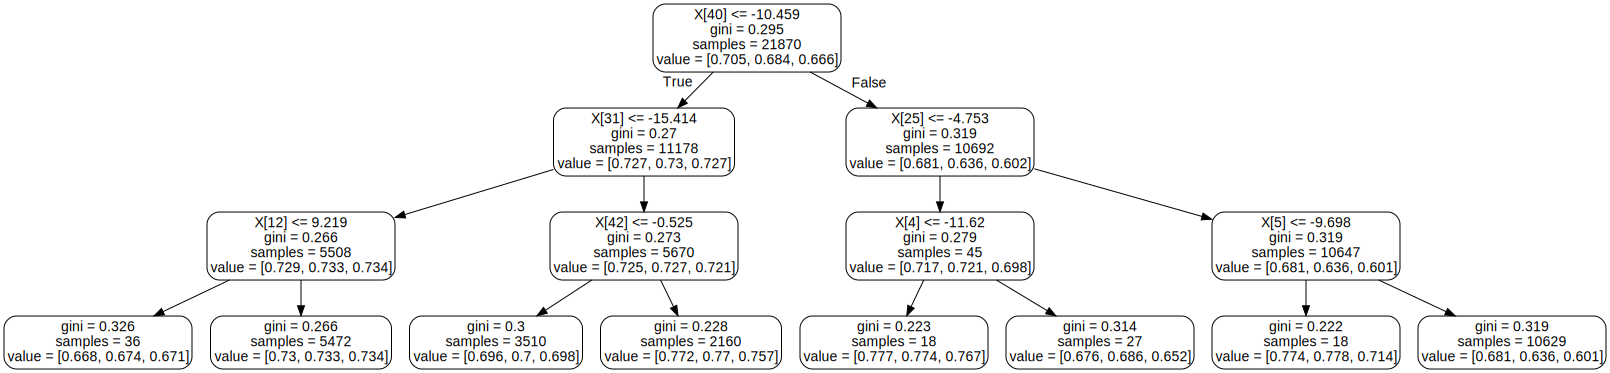

In [42]:
dot_data = export_graphviz(adult_test_cm.model, out_file = None, filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

In [43]:
#test every third database
def get_test_set():
    adult_data_test = []
    for i in range(len(adult_data)):
        if i%3 == 0:
            adult_data_test.append(copy.copy(adult_data[i]))
    default_data_test = []
    for i in range(len(default_data)):
        if i%3 == 0:
            default_data_test.append(copy.copy(default_data[i]))
    lending_data_test = []
    for i in range(len(lending_data)):
        if i%3 == 0:
            lending_data_test.append(copy.copy(lending_data[i]))
    magic_data_test = []
    for i in range(len(magic_data)):
        if i%3 == 0:
            magic_data_test.append(copy.copy(magic_data[i]))
    return (adult_data_test, default_data_test, lending_data_test, magic_data_test)
(adult_data_test, default_data_test, lending_data_test, magic_data_test) = get_test_set()
epsilons = [db.epsilon for db in lending_data_test]

In [25]:
adult_errors = [adult_test_cm.get_errors(x, ratio=0.2) for x in adult_data_test]
adult_errors = pd.concat(adult_errors, ignore_index=True)

In [26]:
lending_errors = [lending_test_cm.get_errors(x, ratio=0.2) for x in lending_data_test]
lending_errors = pd.concat(lending_errors, ignore_index=True)

In [27]:
default_errors = [default_test_cm.get_errors(x, ratio=0.2) for x in default_data_test]
default_errors = pd.concat(default_errors, ignore_index=True)

In [28]:
magic_errors = [magic_test_cm.get_errors(x, ratio=0.2) for x in magic_data_test]
magic_errors = pd.concat(magic_errors, ignore_index=True)

In [44]:
adult_errors2 = [adult_cm.get_errors(x, ratio=0.2) for x in adult_data_test]
adult_errors2 = pd.concat(adult_errors2, ignore_index=True)

In [49]:
adult_errors2.mean(axis=0)

0.1    0.299325
0.5    0.329227
1.0    0.349688
cm     0.298835
dtype: float64

In [53]:
(adult_cm.algs['1.0'].numruns, adult_cm.algs['0.5'].numruns, adult_cm.algs['0.1'].numruns)

(0, 0, 0)

### Kamalika's method

In [29]:
def get_dp_logistic_regression(X_train, y_train, X_test, y_test, 
                             epsilon, ratio, param_list):
    train_eps = epsilon*ratio
    validation_eps = epsilon-train_eps
    #Begin validation
    utils = []
    for C in param_list:
        model = DPLogisticRegression(train_eps, C=C, K=1.02, fit_intercept=True)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        score = (preds == y_test).sum() / y_test.size
        beta = max(1.0/y_test.size, 1.0/y_train.size)
        score += np.random.exponential(1/validation_eps)*beta*2
        utils.append(score)
    return np.array(utils).argmax()

In [30]:
def test_db_MRE(data_test, ratio=0.8, splits=5, do_private=True):
    kf = model_selection.KFold(splits)
    avgs = []
    for db in data_test:
        avg = 0
        for train_idx, test_idx in kf.split(db.X):
            X_val = db.X.iloc[test_idx]
            y_val = db.y.iloc[test_idx]
            X_train = db.X.iloc[train_idx]
            y_train = db.y.iloc[train_idx]
            X_ttrain, X_ttest, y_ttrain, y_ttest = model_selection.train_test_split(X_train, y_train, test_size=0.2)
            if pd.Series.nunique(y_ttrain) == 1:
                avg += 1.0
                continue
            if do_private:
                eps = db.epsilon
            else:
                eps=100
            idx = get_dp_logistic_regression(X_ttrain, y_ttrain, X_ttest, y_ttest, eps, ratio, C_list)
            alg = DP(C_list[idx])
            if do_private:
                alg.model.set_epsilon(eps - (1-ratio)*eps)
            else:
                alg.model.set_epsilon(100)
            alg.model.fit(X_ttrain, y_ttrain)
            y_hat = alg.model.predict(X_val)
            avg += (y_hat == y_val).sum() / y_val.size
        avg /= splits
        avgs.append(1.0-avg)
    return np.array(avgs)

In [31]:
"""Performance of ERM on each dataset slice. We generate the test sets freshly because
the choicemaker alters epsilon yet we need the same amount of budget.
"""
(adult_data_test, default_data_test, lending_data_test, magic_data_test) = get_test_set()
adult_perf = test_db_MRE(adult_data_test)
lending_perf = test_db_MRE(lending_data_test)
default_perf = test_db_MRE(default_data_test)
magic_perf = test_db_MRE(magic_data_test)

In [32]:
"""Performance of non-private cross-validation on each dataset partition. """
(adult_data_test, default_data_test, lending_data_test, magic_data_test) = get_test_set()
adult_perf_non = test_db_MRE(adult_data_test, do_private=False)
lending_perf_non = test_db_MRE(lending_data_test, do_private=False)
default_perf_non = test_db_MRE(default_data_test, do_private=False)
magic_perf_non = test_db_MRE(magic_data_test, do_private=False)

In [33]:
adult_errors['Stability'] = adult_perf
adult_errors['NonPrivate'] = adult_perf_non
adult_errors['eps'] = epsilons
lending_errors['Stability'] = lending_perf
lending_errors['NonPrivate'] = lending_perf_non
lending_errors['eps'] = epsilons
default_errors['Stability'] = default_perf
default_errors['NonPrivate'] = default_perf_non
default_errors['eps'] = epsilons
magic_errors['Stability'] = magic_perf
magic_errors['NonPrivate'] = magic_perf_non
magic_errors['eps'] = epsilons

In [41]:
"""
pickle.dump(adult_errors, open('log_regression_metadata/adult_results2.pkl', 'wb'))
pickle.dump(lending_errors, open('log_regression_metadata/lending_results2.pkl', 'wb'))
pickle.dump(default_errors, open('log_regression_metadata/default_results2.pkl', 'wb'))
pickle.dump(magic_errors, open('log_regression_metadata/megic_results2.pkl', 'wb'))
"""

In [56]:
adult_errors2['Stability'] = adult_perf
adult_errors2['NonPrivate'] = adult_perf_non
adult_errors2['eps'] = epsilons

In [80]:
tst = adult_errors2.groupby('eps').mean()

In [60]:
tst = pd.concat([adult_errors, lending_errors, default_errors, magic_errors], ignore_index=True).groupby('eps').mean()

In [35]:
import matplotlib.patches as mpatches

Text(0.5,1,'Errors of Stability, C_reg, and NonPrivate over 4 datasets')

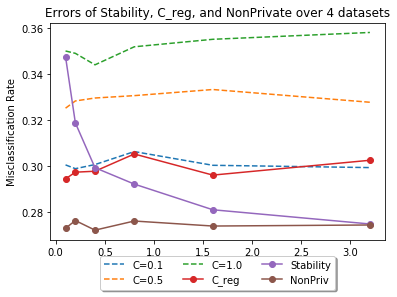

In [81]:
fig, axis=plt.subplots()
for a in alg_list:
    axis.plot(tst.index, tst[a.name], '--', label='C=%s' % a.name)
axis.plot(tst.index, tst['cm'], 'o-', label='C_reg')
axis.plot(tst.index, tst['Stability'], 'o-', label='Stability')
axis.plot(tst.index, tst['NonPrivate'], 'o-', label='NonPriv')
axis.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=3)
axis.set_ylabel('Misclassification Rate')
axis.set_title('Errors of Stability, C_reg, and NonPrivate over 4 datasets')

In [68]:
adult_cm.regrets.mean(axis=0)

0.1    0.300858
0.5    0.328354
1.0    0.349988
dtype: float64

In [77]:
adult_data_test

 ...]

In [79]:
adult_data_test[0]